In [19]:
# python v3.10.11
# import necessary packages

import os
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd

from matplotlib.colors import LogNorm
from matplotlib_venn import venn3
from matplotlib_venn.layout.venn3 import DefaultLayoutAlgorithm


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# set directory and get relevant files

os.chdir('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\model_outputs\\')
death_pvals = pd.read_excel('death_classifier_probes.xlsx', index_col=0)
pinv_pvals = pd.read_excel('pseudoinverse_probes_filtered.xlsx', index_col=0)
ffm_pvals = pd.read_excel('pseudoinverse_probes_ffm_filtered.xlsx', index_col=0)

In [21]:
# m16 fat-free mass probes
FFM_probes = ffm_pvals['M16_poststress_FFM_g_pval']
FFM_probes = FFM_probes.dropna()
FFM_probes = FFM_probes[FFM_probes < 0.01]
FFM_probes = list(FFM_probes.index)
print(f'Number of m16 fat-free mass probes: {len(FFM_probes)}')

# m14 blood glucose probes
GLU_probes_M14 = pinv_pvals['M14_poststress_GLU_pval']
GLU_probes_M14 = GLU_probes_M14.dropna()
GLU_probes_M14 = GLU_probes_M14[GLU_probes_M14 < 0.01]
GLU_probes_M14 = list(GLU_probes_M14.index)
print(f'Number of m14 blood glucose probes: {len(GLU_probes_M14)}')

# aging probes
age_probes = death_pvals
age_probes = age_probes.dropna()
age_probes = list(age_probes.index)
print(f'Number of aging probes: {len(age_probes)}')

##

glu_intersections = list(set(GLU_probes_M14) & set(age_probes))
fi_intersections = list(set(FFM_probes) & set(age_probes))
all_intersect = list(set(glu_intersections) & set(fi_intersections))

all_cross = death_pvals.loc[all_intersect]
all_cross = all_cross[['coef', 'associated_genes']]
all_cross = all_cross.rename_axis('ID').reset_index()
print(f'Number of probes intersected between w16 food intake, blood glucose, and aging: {len(all_cross)}')


glu_cross = death_pvals.loc[glu_intersections]
glu_cross = glu_cross[['coef', 'associated_genes']]
glu_cross = glu_cross.rename_axis('ID').reset_index()
print(f'Number of m14 blood glucose probes intersected with aging: {len(glu_cross)}')


fi_cross = death_pvals.loc[fi_intersections]
fi_cross = fi_cross[['coef', 'associated_genes']]
fi_cross = fi_cross.rename_axis('ID').reset_index()
print(f'Number of w16 food intake probes intersected with aging: {len(fi_cross)}')

Number of m16 fat-free mass probes: 1728
Number of m14 blood glucose probes: 46
Number of aging probes: 9363
Number of probes intersected between w16 food intake, blood glucose, and aging: 2
Number of m14 blood glucose probes intersected with aging: 24
Number of w16 food intake probes intersected with aging: 183


In [22]:
'''
Define functions for plot generation
'''

# extract genes from associated_genes column
def extract_genes(gene_string):
    genes = []
    n_genes = gene_string.count(', ')
    n = 0
    while n < n_genes + 1:
        index_space = gene_string.find(' ')
        gene_n = gene_string[:index_space]
        genes.append(gene_n)
        index_comma = gene_string.find(', ')
        gene_string = gene_string[index_comma + 2:]
        n += 1
    return genes

# apply the function to each entry in 'associated_genes' column
def apply_gene_extraction(cross_identified_probes):
    associated_genes_full = [gene for gene in cross_identified_probes['associated_genes']]
    cross_identified_probes['genes'] = cross_identified_probes['associated_genes'].apply(extract_genes)

    # Count occurrences of each gene across all entries
    gene_counts = pd.Series([gene for genes_list in cross_identified_probes['genes'] for gene in genes_list]).value_counts()
    return associated_genes_full, gene_counts

# define marker style based on duplication status
def define_marker_style(cross_identified_probes, gene_counts):
    duplicates = gene_counts[gene_counts > 1].index.tolist()
    marker_style = []
    for genes in cross_identified_probes['associated_genes']:
        to_append = '^'
        for gene in duplicates:
            if gene in genes:
                to_append = 'o'
        marker_style.append(to_append)
    return marker_style, duplicates

# Function to plot scatter plot with dynamic data
def plot_scatter(ax, cross_identified_probes):
    associated_genes_full, gene_counts = apply_gene_extraction(cross_identified_probes)
    marker_style, duplicates = define_marker_style(cross_identified_probes, gene_counts)

    sns.scatterplot(data=cross_identified_probes, x='coef', y='ID', style=marker_style, s=200, 
                    legend=False, palette='viridis_d', hue='coef', ax=ax)

    # Add legend showing repeated genes
    props = dict(boxstyle='round', facecolor='green', alpha=0.5)
    gene_list_formatted = '\n'.join(duplicates)
    ax.text(0.03, 0.96, f'Duplicated Genes:\n\n{gene_list_formatted}', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Annotate each point with associated genes
    for i, genes in enumerate(associated_genes_full):
        x = cross_identified_probes['coef'][i]
        y = cross_identified_probes.index[i]
        ax.annotate(genes, (x, y), textcoords="offset points", xytext=(10, -3), ha='left', size=9)

    ax.set_xlabel('elastic net coefficient', size=18)
    ax.set_ylabel('probes', size=18)
    ax.set_facecolor((1, 1, 0.8509803921))  # Same as plot included in same figure
    ax.set_xlim(-0.1, 0.3)

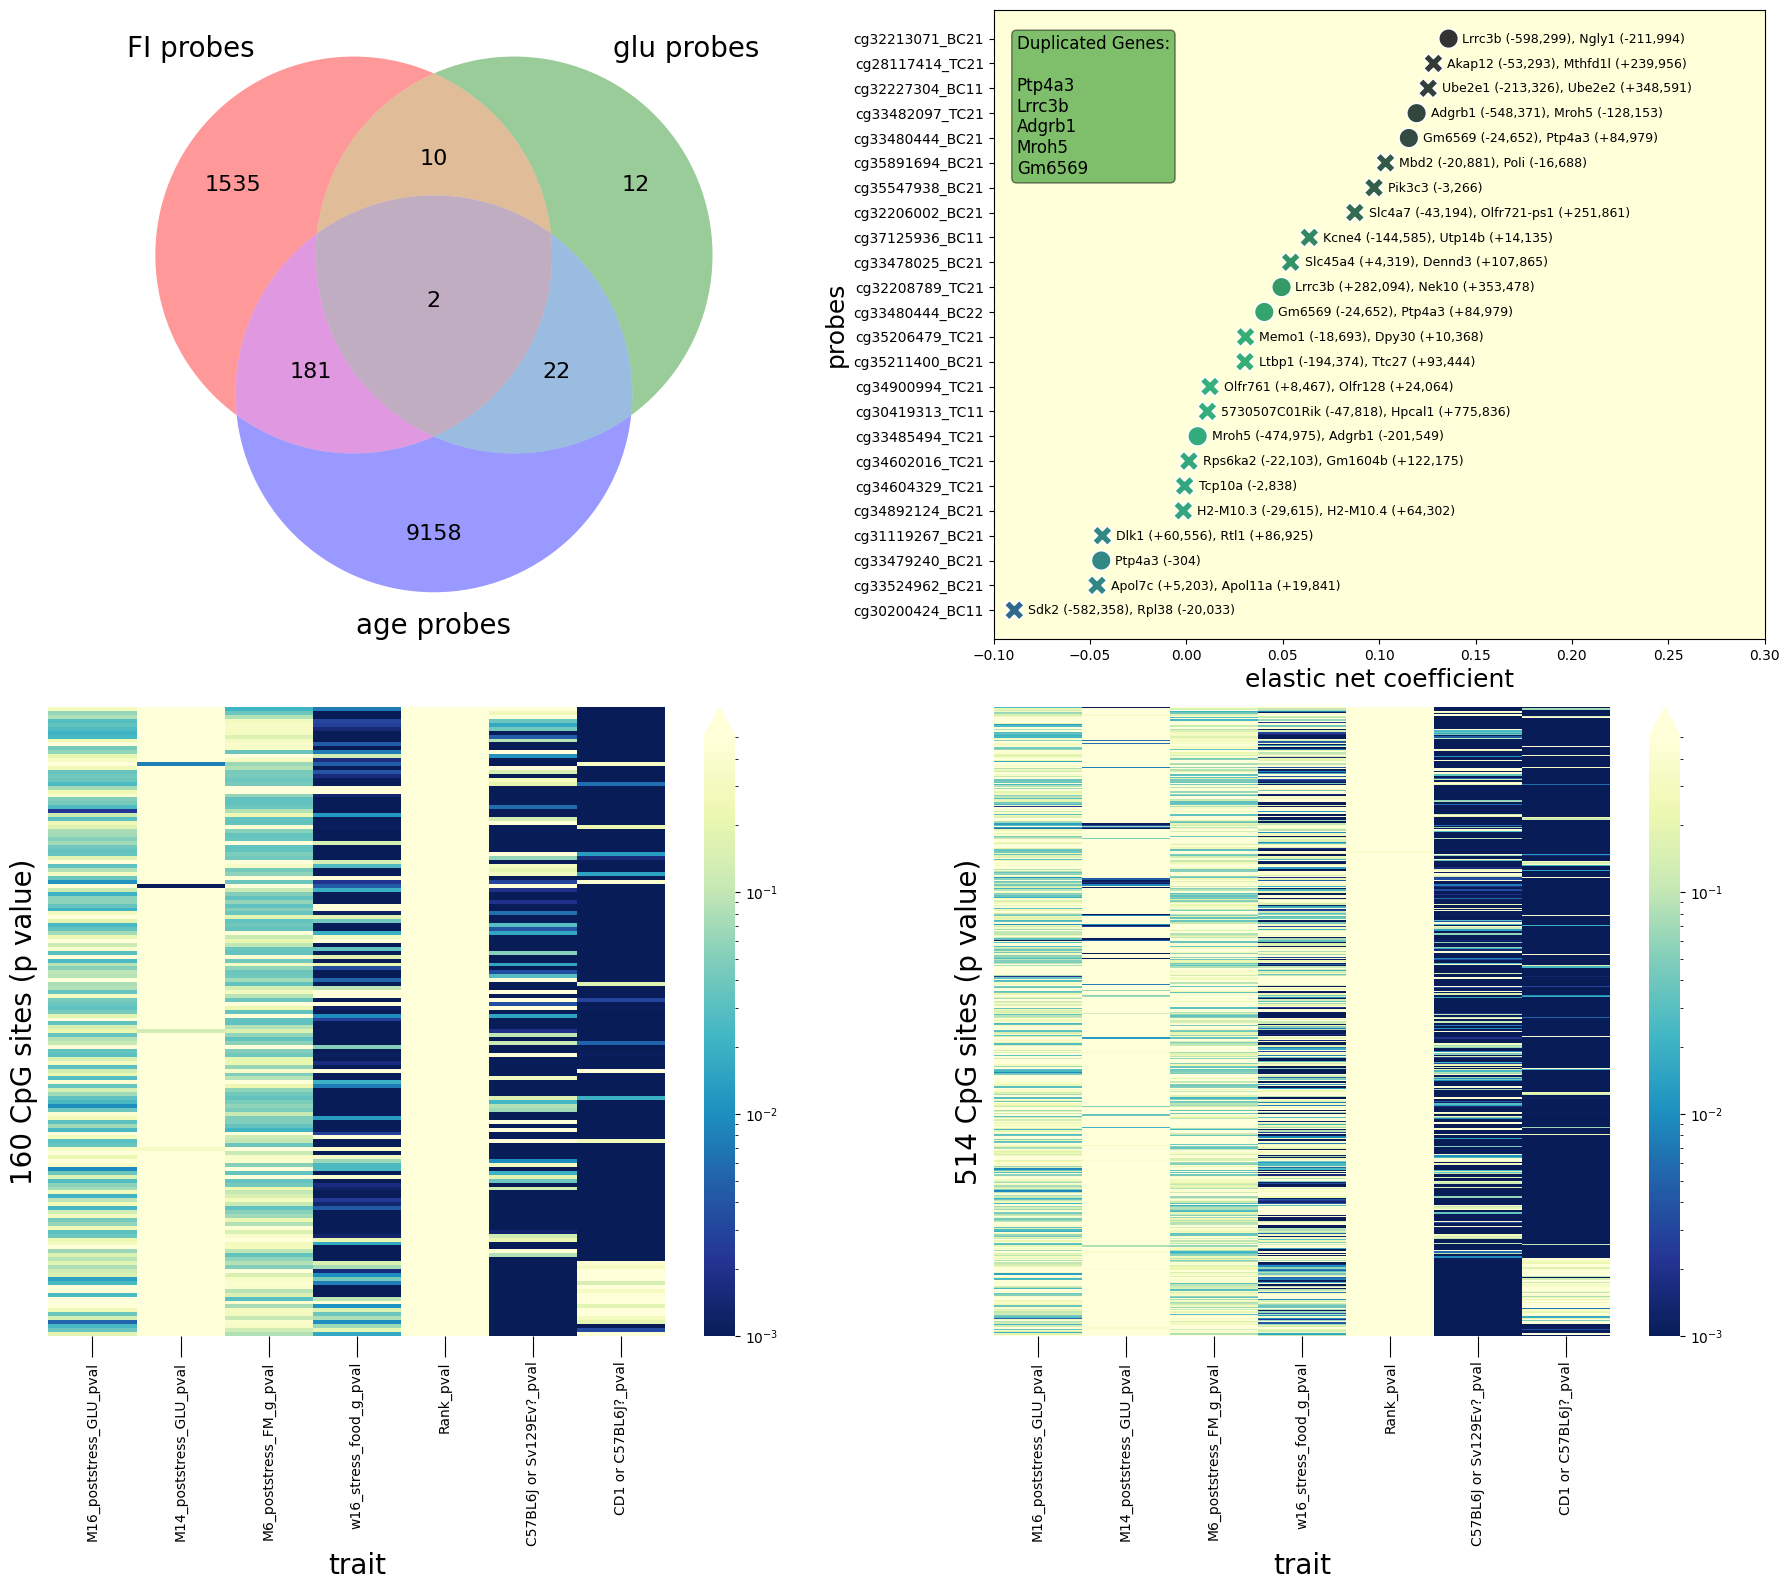

In [23]:
# Sort elastic net by value so the legend isn't obscured
cross_identified_probes_1 = all_cross.sort_values(by='coef', ascending=False, ignore_index=True)
cross_identified_probes_2 = glu_cross.sort_values(by='coef', ascending=False, ignore_index=True)
cross_identified_probes_3 = fi_cross.sort_values(by='coef', ascending=False, ignore_index=True)

# Create 4 subplots (2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(18, 16))  # Adjust the figure size as needed


# plot 1
set1 = set(FFM_probes)      
set2 = set(GLU_probes_M14) 
set3 = set(age_probes)  

venn = venn3([set1, set2, set3], ('FI probes', 'glu probes', 'age probes'), ax=axs[0, 0], layout_algorithm=DefaultLayoutAlgorithm(fixed_subset_sizes=(1,1,1,1,1,1,1)))

# adjust params
for text in venn.set_labels:
    text.set_fontsize(20)

for text in venn.subset_labels:
    text.set_fontsize(16) 

# plot 2
plot_scatter(axs[0, 1], cross_identified_probes_2)

# plot 3
probes = pinv_pvals.index.intersection(fi_intersections)
model_intersection = pinv_pvals.loc[probes].copy()

for column in model_intersection.columns:
    if 'coef' in column: model_intersection.drop(columns=[column], inplace=True)
    elif 'mm39' in column: model_intersection.drop(columns=[column], inplace=True)
    elif 'mm10' in column: model_intersection.drop(columns=[column], inplace=True)
    elif 'gene' in column: model_intersection.drop(columns=[column], inplace=True)

sns.heatmap(model_intersection, norm=LogNorm(vmin=0.001, vmax=0.5),
            cmap='YlGnBu_r', cbar_kws={'extend': 'max'}, ax=axs[1, 0])

axs[1, 0].set_ylabel(f'{model_intersection.shape[0]} CpG sites (p value)', fontsize=20)
axs[1, 0].set_xlabel('trait', fontsize=20)
axs[1, 0].set_yticks([])
axs[1, 0].tick_params('x', rotation=90, size=15)


# plot 4
probes = pinv_pvals.index.intersection(age_probes)
model_intersection = pinv_pvals.loc[probes].copy()

for column in model_intersection.columns:
    if 'coef' in column: model_intersection.drop(columns=[column], inplace=True)
    elif 'mm39' in column: model_intersection.drop(columns=[column], inplace=True)
    elif 'mm10' in column: model_intersection.drop(columns=[column], inplace=True)
    elif 'gene' in column: model_intersection.drop(columns=[column], inplace=True)

sns.heatmap(model_intersection, norm=LogNorm(vmin=0.001, vmax=0.5),
            cmap='YlGnBu_r', cbar_kws={'extend': 'max'}, ax=axs[1, 1])

axs[1, 1].set_ylabel(f'{model_intersection.shape[0]} CpG sites (p value)', fontsize=20)
axs[1, 1].set_xlabel('trait', fontsize=20)
axs[1, 1].set_yticks([])
axs[1, 1].tick_params('x', rotation=90, size=15)

plt.tight_layout()
plt.show()

In [24]:
# print the probes intersected within the regions

print(all_cross)

                ID      coef                associated_genes
0  cg33479240_BC21 -0.044193                   Ptp4a3 (-304)
1  cg31119267_BC21 -0.043582  Dlk1 (+60,556), Rtl1 (+86,925)


In [25]:
# export food intake probes as table

fi_cross.to_excel('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\model_outputs\\wk16_food_intake_aging_intersection.xlsx')